In [29]:
import math
import queue
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
from pprint import pprint
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import warnings
FILE_FOLDER = '../prediction_data/%s'
AFTER_FILE_FOLDER = '../prediction_data/afterAnalysis/%s'
MODELS_FOLDER = '../prediction_data/afterAnalysis/models/%s'

# Load data

In [2]:
df_train_with_weather = pd.read_csv(AFTER_FILE_FOLDER%'after_second_filling.csv')
df_train_with_weather.head()
train_fea = ['temperature', 'humidity', 'pressure','wind_speed', 'year', 'month', 'day', 'hour']
label_fea = ['PM25', 'PM10', 'O3']
date_fear = ['year', 'month', 'day', 'hour']
weather_fea = ['temperature', 'humidity', 'pressure','wind_speed']
# ['station_id', 'time', 'temperature', 'humidity', 'pressure',
#        'wind_speed', 'PM25', 'PM10', 'O3', 'year', 'month', 'day', 'hour']

In [3]:
aq_station_name = ['tiantan_aq', 'guanyuan_aq', 'wanshouxigong_aq',
                   'aotizhongxin_aq', 'nongzhanguan_aq', 'wanliu_aq', 'beibuxinqu_aq', 
                   'zhiwuyuan_aq', 'fengtaihuayuan_aq', 'yungang_aq', 'gucheng_aq', 
                   'fangshan_aq', 'daxing_aq', 'yizhuang_aq', 'tongzhou_aq',
                   'shunyi_aq', 'pingchang_aq', 'mentougou_aq', 'pinggu_aq', 
                   'huairou_aq', 'miyun_aq', 'yanqin_aq', 'dingling_aq', 'badaling_aq', 
                   'miyunshuiku_aq', 'donggaocun_aq', 'yongledian_aq', 'yufa_aq', 
                   'liulihe_aq', 'qianmen_aq', 'yongdingmennei_aq', 'xizhimenbei_aq',
                   'nansanhuan_aq', 'dongsihuan_aq']
valid_station = 'dongsi_aq'

In [4]:
df_train = df_train_with_weather[df_train_with_weather['station_id'].isin(aq_station_name)][train_fea + label_fea]
df_validation = df_train_with_weather[df_train_with_weather['station_id'] == valid_station][train_fea + label_fea]

In [8]:
# df_train_with_weather['PM25'].max(axis=0),df_train_with_weather['PM10'].max(axis=0),
# df_train_with_weather['O3'].max(axis=0)

label_normalize ={
    'PM25': 1600.0,
    'PM10': 3280.0,
    'O3': 505.0,
}
weather_mean = df_train_with_weather[weather_fea].mean()
weather_std = df_train_with_weather[weather_fea].std()

In [71]:
weather_mean.values

array([  11.22762278,   38.31801686, 1000.83969531,    8.81584084])

In [74]:
weather_std.values

array([11.79542851, 20.34041789, 21.30626417,  6.00146496])

In [9]:
def get_train_validation_data(df_train,df_validation,pollution_name):
    train_X = df_train[train_fea].copy()
    train_X[weather_fea] = (train_X[weather_fea] - weather_mean)/weather_std
    train_y = df_train[label_fea][pollution_name] / label_normalize[pollution_name]
    
    val_X = df_validation[train_fea].copy()
    val_X[weather_fea] = (val_X[weather_fea] - weather_mean)/weather_std
    val_y = df_validation[label_fea][pollution_name] / label_normalize[pollution_name]
    return train_X,val_X,train_y,val_y

# LightGBM
## Train model

In [37]:
# params = {
#     'learning_rate': 0.01,
#     'boosting_type': 'gbdt',
# #     'objective': 'regression',
#     'application': 'mape',
#     'metric': 'map',
#     'sub_feature': 0.7,
#     'num_leaves': 60,
#     'min_data': 100,
#     'min_hessian': 1,
#     'verbose': -1,
# }
model_param = {'lr': 0.01, 'depth': 10, 'tree': 5000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'l2', 'l1'},
    'max_depth': model_param['depth'],
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'feature_fraction': 1,
    'bagging_fraction': model_param['sample'],
    'bagging_freq': 1,
    'bagging_seed': model_param['seed'],
    'verbose': 0
}

In [42]:
for p_name in label_normalize.keys():
    train_X,val_X,train_y,val_y = get_train_validation_data(df_train,df_validation,p_name)
    
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_eval = lgb.Dataset(val_X, val_y)
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=5000,
        valid_sets=lgb_eval,
        verbose_eval = 100,
        early_stopping_rounds = 100
    )
    gbm.save_model(MODELS_FOLDER%('gmb_model_%s.txt'%p_name),num_iteration=gbm.best_iteration)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000527945	valid_0's l1: 0.0160266
[200]	valid_0's l2: 0.000275997	valid_0's l1: 0.0115703
[300]	valid_0's l2: 0.000198643	valid_0's l1: 0.00959106
[400]	valid_0's l2: 0.000162463	valid_0's l1: 0.00847582
[500]	valid_0's l2: 0.000141241	valid_0's l1: 0.0077606
[600]	valid_0's l2: 0.000129038	valid_0's l1: 0.00730163
[700]	valid_0's l2: 0.000119935	valid_0's l1: 0.00693143
[800]	valid_0's l2: 0.000113361	valid_0's l1: 0.00665302
[900]	valid_0's l2: 0.000108697	valid_0's l1: 0.00644681
[1000]	valid_0's l2: 0.000104866	valid_0's l1: 0.00627712
[1100]	valid_0's l2: 0.000101731	valid_0's l1: 0.00613581
[1200]	valid_0's l2: 9.92234e-05	valid_0's l1: 0.00601879
[1300]	valid_0's l2: 9.70629e-05	valid_0's l1: 0.00591973
[1400]	valid_0's l2: 9.49341e-05	valid_0's l1: 0.00582295
[1500]	valid_0's l2: 9.32143e-05	valid_0's l1: 0.0057398
[1600]	valid_0's l2: 9.15717e-05	valid_0's l1: 0.00565831
[1700]	valid_0's l2: 9

[3800]	valid_0's l2: 0.00070528	valid_0's l1: 0.0164407
[3900]	valid_0's l2: 0.000703772	valid_0's l1: 0.0164167
[4000]	valid_0's l2: 0.000702591	valid_0's l1: 0.0163953
[4100]	valid_0's l2: 0.000701563	valid_0's l1: 0.0163759
[4200]	valid_0's l2: 0.000700477	valid_0's l1: 0.0163569
[4300]	valid_0's l2: 0.000699419	valid_0's l1: 0.0163392
[4400]	valid_0's l2: 0.000698706	valid_0's l1: 0.0163242
[4500]	valid_0's l2: 0.000697796	valid_0's l1: 0.0163083
[4600]	valid_0's l2: 0.000696927	valid_0's l1: 0.0162919
[4700]	valid_0's l2: 0.000696248	valid_0's l1: 0.0162795
[4800]	valid_0's l2: 0.000695564	valid_0's l1: 0.0162678
[4900]	valid_0's l2: 0.000694882	valid_0's l1: 0.0162551
[5000]	valid_0's l2: 0.000694161	valid_0's l1: 0.0162432
Did not meet early stopping. Best iteration is:
[4998]	valid_0's l2: 0.000694161	valid_0's l1: 0.0162431


## Prediction & Validation

In [75]:
def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), 
                                 where=denominator!=0, casting='unsafe'))
def true_pred_plot(pred,val_y,label):
    warmup_steps = 48
    signal_pred = pred[:warmup_steps]

    # Get the true output-signal from the data-set.
    signal_true = val_y[:warmup_steps]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')

    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

    # Plot labels etc.
    plt.ylabel(label)
    plt.legend()
    plt.show()

Symmetric mean absolute percentage error at PM25 : 0.18777856782419522


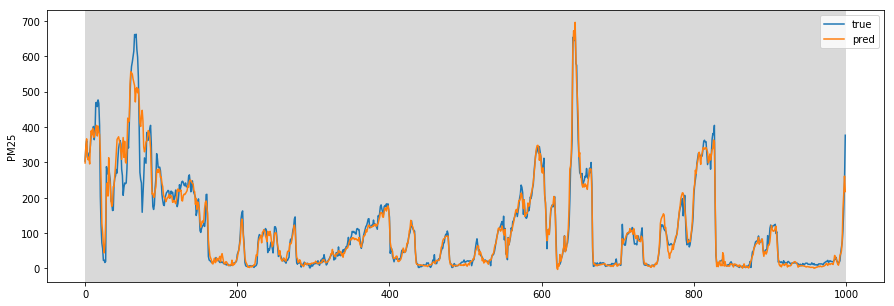

Symmetric mean absolute percentage error at PM10 : 0.1718979726527592


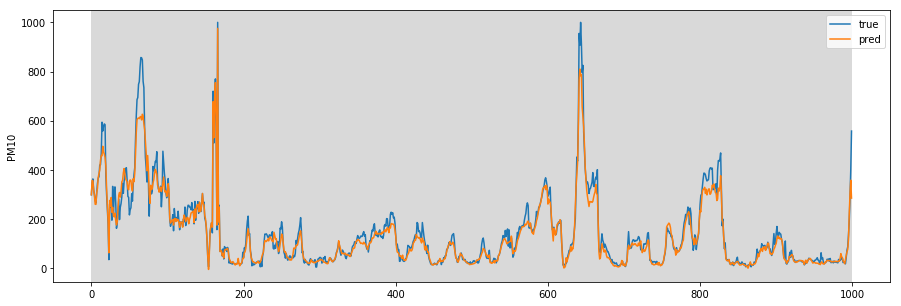

Symmetric mean absolute percentage error at O3 : 0.30953221778993434


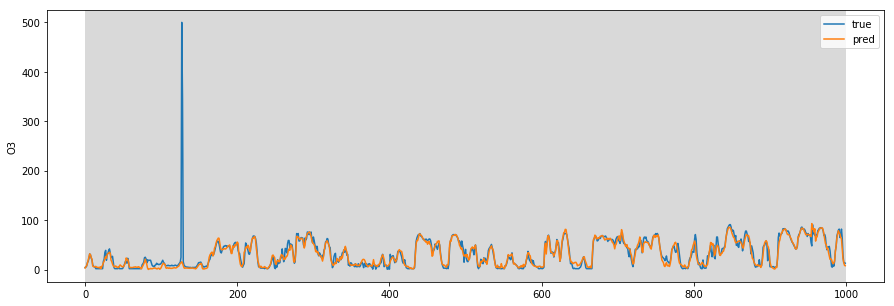

In [41]:
label_normalize ={
    'PM25': 1600.0,
    'PM10': 3280.0,
    'O3': 505.0,
}
LABELS = label_normalize.keys()

for label in LABELS:
    train_X,val_X,train_y,val_y = get_train_validation_data(df_train,df_validation,label)
    gbm = lgb.Booster(model_file = MODELS_FOLDER % ('gmb_model_%s.txt'%label))
    pred = gbm.predict(val_X)
    
    pred_nor = pred * label_normalize[label]
    val_y_nor = val_y.values * label_normalize[label]
    print('Symmetric mean absolute percentage error at %s :'%label, smape(val_y_nor,pred_nor))
    true_pred_plot(pd.Series(pred_nor),pd.Series(val_y_nor),label)

# LightGBM with log

In [45]:
def get_train_validation_data_with_log(df_train,df_validation,pollution_name):
    train_X = df_train[train_fea].copy()
    train_X[weather_fea] = (train_X[weather_fea] - weather_mean)/weather_std
    train_y = np.log(df_train[label_fea][pollution_name])
    
    val_X = df_validation[train_fea].copy()
    val_X[weather_fea] = (val_X[weather_fea] - weather_mean)/weather_std
    val_y = np.log(df_validation[label_fea][pollution_name])
    return train_X,val_X,train_y,val_y

In [46]:
for p_name in label_normalize.keys():
    train_X,val_X,train_y,val_y = get_train_validation_data_with_log(df_train,df_validation,p_name)
    
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_eval = lgb.Dataset(val_X, val_y)
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=5000,
        valid_sets=lgb_eval,
        verbose_eval = 100,
        early_stopping_rounds = 100
    )
    gbm.save_model(MODELS_FOLDER%('gmb_model_%s_log.txt'%p_name),num_iteration=gbm.best_iteration)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.394952	valid_0's l1: 0.508798
[200]	valid_0's l2: 0.229449	valid_0's l1: 0.373015
[300]	valid_0's l2: 0.171983	valid_0's l1: 0.314071
[400]	valid_0's l2: 0.144416	valid_0's l1: 0.283435
[500]	valid_0's l2: 0.12812	valid_0's l1: 0.263665
[600]	valid_0's l2: 0.116458	valid_0's l1: 0.249142
[700]	valid_0's l2: 0.108344	valid_0's l1: 0.238417
[800]	valid_0's l2: 0.102454	valid_0's l1: 0.230296
[900]	valid_0's l2: 0.09733	valid_0's l1: 0.223328
[1000]	valid_0's l2: 0.0936066	valid_0's l1: 0.218097
[1100]	valid_0's l2: 0.090557	valid_0's l1: 0.213645
[1200]	valid_0's l2: 0.0881769	valid_0's l1: 0.21011
[1300]	valid_0's l2: 0.086188	valid_0's l1: 0.207092
[1400]	valid_0's l2: 0.0843759	valid_0's l1: 0.204244
[1500]	valid_0's l2: 0.0828362	valid_0's l1: 0.201783
[1600]	valid_0's l2: 0.0815446	valid_0's l1: 0.199726
[1700]	valid_0's l2: 0.0802449	valid_0's l1: 0.197654
[1800]	valid_0's l2: 0.0790877	valid_0's l

[4800]	valid_0's l2: 0.246963	valid_0's l1: 0.321696
[4900]	valid_0's l2: 0.246804	valid_0's l1: 0.321427
[5000]	valid_0's l2: 0.246591	valid_0's l1: 0.321079
Did not meet early stopping. Best iteration is:
[4985]	valid_0's l2: 0.246565	valid_0's l1: 0.321095


Symmetric mean absolute percentage error at PM25 : 0.17182235256851047


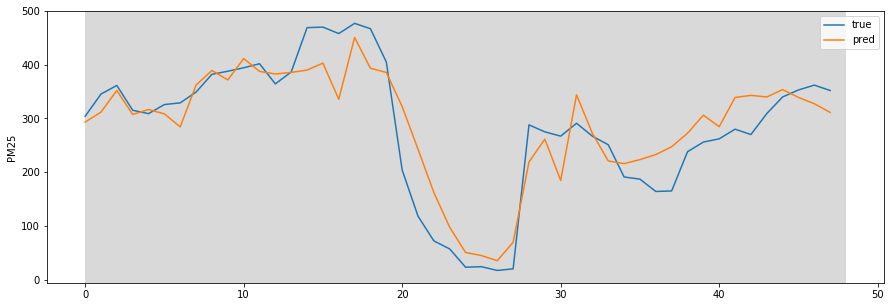

Symmetric mean absolute percentage error at PM10 : 0.15790390417774341


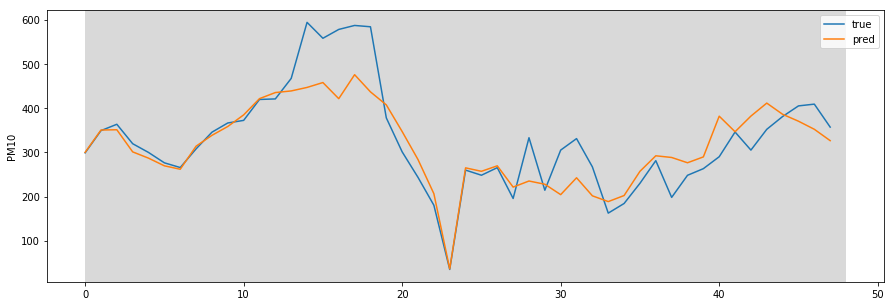

Symmetric mean absolute percentage error at O3 : 0.3015042752633121


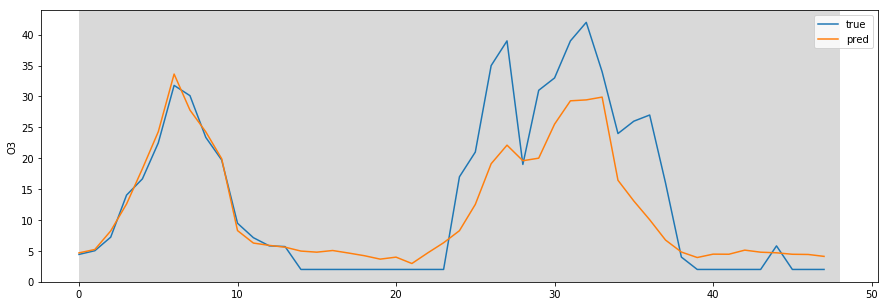

In [76]:
for label in LABELS:
    train_X,val_X,train_y,val_y = get_train_validation_data_with_log(df_train,df_validation,label)
    gbm = lgb.Booster(model_file = MODELS_FOLDER % ('gmb_model_%s_log.txt'%label))
    pred = gbm.predict(val_X)
    
    pred_nor = np.power(np.e,pred) 
    val_y_nor = np.power(np.e,val_y.values)
    print('Symmetric mean absolute percentage error at %s :'%label, smape(val_y_nor,pred_nor))
    true_pred_plot(pd.Series(pred_nor),pd.Series(val_y_nor),label)

In [77]:
((train_X[weather_fea] - weather_mean)/weather_std).describe()

,temperature,humidity,pressure,wind_speed
count,395760.000000,395760.000000,395760.000000,395760.000000
mean,-0.952046,-1.883694,-46.974754,-1.468990
std,0.084788,0.049210,0.047235,0.166718
min,-1.164521,-1.964753,-47.164900,-1.713713
25%,-1.029373,-1.923438,-46.993180,-1.588867
50%,-0.951558,-1.895457,-46.967884,-1.509091
75%,-0.876305,-1.851653,-46.942338,-1.392851
max,-0.773190,-1.734750,-46.889286,-0.204728
